### **Note** 
* All items of problems in problem sets should be done in seperate cells.
* Do not forget to include title, labels of each line and set axis names for every figure you plot.
* You can submit incomplete problems. They will be graded as well.
* Bonus tasks are challenging and non-obligatory. However, they may help you with your final grade.

# Problem 1 (Python demo: convolution of a signal)
## 40 pts

* First of all download one of the $\verb|.wav|$ files with starcraft sounds from [here](https://github.com/oseledets/nla2015/tree/master/lectures). Load them in python and play using functions from [lecture 1](../lectures/bss1.ipynb).

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory. Cut the signal so that you will not have swap (overflow of the operation memory).


* Create matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad \alpha = \frac{1}{20}, \quad i,j=1,\dots,N.$$ Avoid using loops or lists! The function [scipy.linalg.toeplitz](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.toeplitz.html) might be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is called **convolution**.


* Multiply matrix $T$ by your signal (for matvec operations use $\verb|numpy|$ package). Plot first $100$ points of the result and first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using subplots in matplotlib. Make sure that you got results that look like slighly smoothed initial signal.


* Play the resulting signal. In order to do so format your array into $\verb|int16|$ before playing by using
```python
your_array = your_array.astype(np.int16)
```


* Measure times of multiplications by $T$ for different values of $N$ and plot them in loglog scale. What is the slope of this line? Why?

# Solution - 1:
##  1) Loading .wav file:

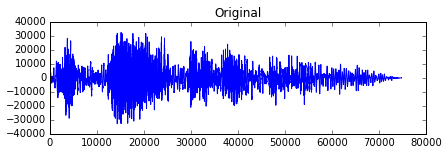

In [2]:
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
%matplotlib inline
import sys
def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

#The first sound
import pylab as pl
# load
fs1,s1 = load_wav('tbawht02.wav') # Terran Battlecruiser - "Good day, commander."
# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Original')
pl.show()

# player
wavPlayer(s1, fs1)

## 2) Estimating affordable matrix size:

$N^2*8$=$avaliable\_cache$ 

Let's say I have 1.5 Gb of cache available. It means that number of available bytes is 1610612736, so I can afford to hold in the memory  a square matrix with size equal approximately 14189.


## 3) Creating T matrix:

In [3]:
def formula(i,a):
    c=np.sqrt(a/np.pi)
    return c*np.exp(-a*i**2)

def T_matrix(size,a):
    T_row=np.arange(size)
    T_row=formula(T_row,a)
    from scipy.linalg import toeplitz
    T=toeplitz(T_row)
    return T
    
print T_matrix(14189,0.05)

[[ 0.12615663  0.12000389  0.10328831 ...,  0.          0.          0.        ]
 [ 0.12000389  0.12615663  0.12000389 ...,  0.          0.          0.        ]
 [ 0.10328831  0.12000389  0.12615663 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.12615663  0.12000389
   0.10328831]
 [ 0.          0.          0.         ...,  0.12000389  0.12615663
   0.12000389]
 [ 0.          0.          0.         ...,  0.10328831  0.12000389
   0.12615663]]


## 4) Multiplying matrix T by a signal:

In [4]:
def multi(T,s1,T_size):
    if(len(s1)<len(T[0])):
        s1.apend(np.zeros(len(T[0])-len(s1)))
    T1=np.dot(T,s1[0:T_size])
    limit=(s1.size-T_size)//T_size*T_size
    for i in xrange(T_size+1,limit,T_size):
        T2=np.dot(T,s1[i:i+T_size])
        T1=np.append(T1,T2)
        T1=T1.astype(np.int16)
    return T1


def calc_array(a,s1):
    T=T_matrix(14189,a)
    return multi(T,s1,14189)

print calc_array(0.05,s1)

[  329   418   505 ..., -1492 -1237  -977]


## 5)Ploting first 100 points of the result and first 100 points of a signal on the same figure:

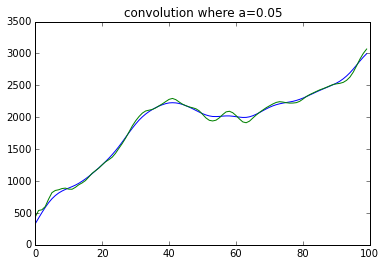

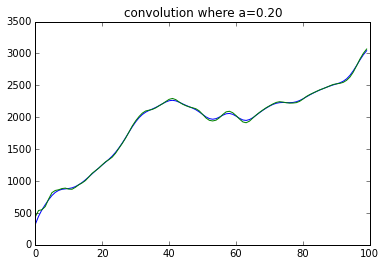

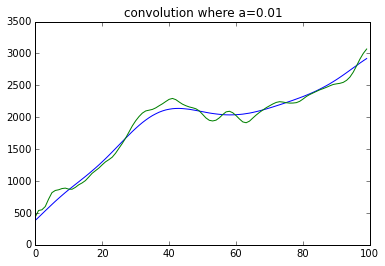

In [5]:
convolution_05=calc_array(0.05,s1)
pl.plot(convolution_05[0:100])
pl.plot(s1[0:100])
pl.title('convolution where a=0.05')
pl.show()
# player

convolution_20=calc_array(0.20,s1)
pl.plot(convolution_20[0:100])
pl.plot(s1[0:100])
pl.title('convolution where a=0.20')
pl.show()
# player


convolution_01=calc_array(0.01,s1)
pl.plot(convolution_01[0:100])
pl.plot(s1[0:100])
pl.title('convolution where a=0.01')
pl.show()
# player

## 6) Playing convolutions:

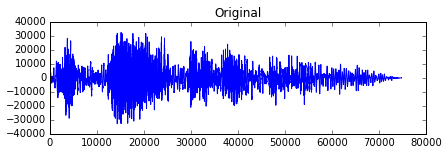

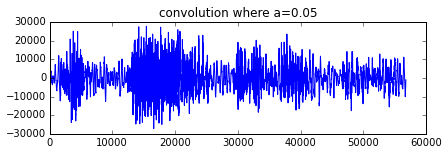

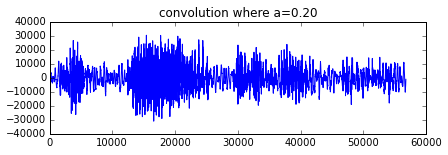

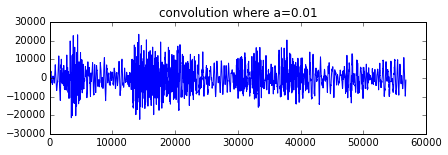

In [6]:
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Original')
pl.show()
wavPlayer(s1, fs1)

pl.figure(figsize=(6.75,2))
pl.plot(convolution_05)
pl.title('convolution where a=0.05')
pl.show()
# player
wavPlayer(convolution_05, fs1)

pl.figure(figsize=(6.75,2))
pl.plot(convolution_20)
pl.title('convolution where a=0.20')
pl.show()
# player
wavPlayer(convolution_20, fs1)

pl.figure(figsize=(6.75,2))
pl.plot(convolution_01)
pl.title('convolution where a=0.01')
pl.show()
# player
wavPlayer(convolution_01, fs1)

## 7) Measureing times of multiplications by T for different values of N:

[100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100]


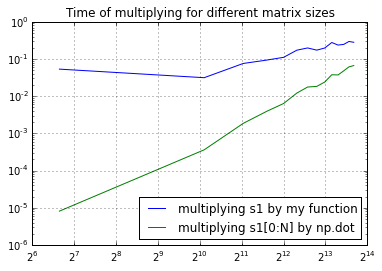

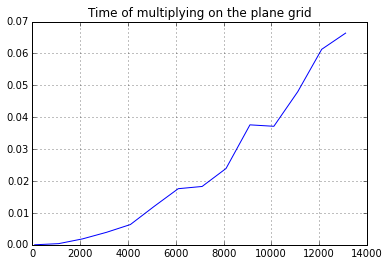

In [7]:
import time as t
time_array=[]
right_time_array=[]
n_array=[100+1000*i for i in range(14)]
print n_array
for N in n_array:
    T=T_matrix(N,0.05)
    start_time = t.time()
    multi(T,s1,N)
    time_array.append(t.time()- start_time)
    start_time = t.time()
    np.dot(T,s1[0:N])
    right_time_array.append(t.time()- start_time)



pl.loglog(n_array,time_array, basex=2,label='multiplying s1 by my function')
pl.loglog(n_array,right_time_array, basex=2,label='multiplying s1[0:N] by np.dot')
pl.grid(True)
pl.title('Time of multiplying for different matrix sizes')
pl.legend(loc="best")
pl.show()

pl.plot(n_array,right_time_array,label='multiplying s1[0:N] by np.dot')
pl.title('Time of multiplying on the plane grid')
pl.grid(True)
pl.show()

In [204]:
slope, intercept = np.polyfit(np.log(n_array), np.log(right_time_array), 1)
print 'slope =',slope

slope = 1.89405504425


# Problem 2 (Instability of the standard Gram-Schmidt algorithm)

## 30 pts
Our goal now is to orthogonalize a system of linearly independent vectors $v_1,\dots,v_n$.
The standard algorithm for the task is the Gram-Schmidt algorithm:
$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
u_3 &= v_3 - \frac{(v_3, u_1)}{(u_1, u_1)} u_1 - \frac{(v_3, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$
Now $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to get orthonormal system you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.

* Implement the described Gram-Schmidt algorithm and check it on a random $10\times 10$ matrix. **Note:** To check orthogonality calculate the matrix of scalar products $G_{ij} = (u_i, u_j)$ (called Gram matrix) which should be equal to the identity matrix $I$. Error $\|G - I\|$ will show you how far is the system $u_i$ from orthonormal.


* Create a Hilbert matrix of size $10\times 10$ without using loops.


* Othogonalize its columns by the described Gram-Schmidt algorithm. Is the Gram matrix close to the identity matrix in this case? How do you think why?

The oberved loss of orthogonality is a problem of this particular algorithm. To avoid it [modified Gram-Schmidt algorithm](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process#Numerical_stability) can be used. Moreover we will talk about more advanced algorithms later (QR decomposition lecture).

# Solution -2 
## 1) Gram-Schmidt function:

In [199]:
import numpy as np

def correction(to, v, u):
    delta=0.
    for i in range (to):
        u_i=u[:,i];
        delta+= (np.dot(v, u_i) / np.dot(u_i, u_i))*u_i
    return delta

def gram(v):
    # Returns the Gramm-Schmidt orthogonalization of matrix X   
    row_number = len(v) 
    for i in range (1,row_number):
        v[:,i]=v[:,i] - correction(i, v[:,i],v)
    for i in range (row_number):
        v[:,i]=v[:,i]/np.linalg.norm(v[:,i])
    return v

## 2) Checking for a random 10×10 matrix:

In [200]:
n = 10
matrix = gram(np.random.randn(n, n))
G = matrix.T.dot(matrix)
print 'second norm =',np.linalg.norm(G - np.identity(n))
print 'frobenious norm =',np.linalg.norm(G - np.identity(n), 'fro')

second norm = 1.97432190348e-15
frobenious norm = 1.97432190348e-15


##### Result:
Taking into account that the relative accuracy for double-precision is  $10^{14}$-$10^{16}$, I would say it's pretty close to the the identity matrix $I$.

## 3) Creating a Hilbert matrix:

In [201]:
from scipy.linalg import hilbert
matrix = gramm(hilbert(n))
G = matrix.T.dot(matrix)
print 'second norm =',np.linalg.norm(matrix - np.identity(n))
print 'frobenious norm =',np.linalg.norm(matrix - np.identity(n), 'fro')

second norm = 4.43685440528
frobenious norm = 4.43685440528


## Result:
Here there is another story: when total error has become large enough the accuracy was totally destroyed.

# Problem 3 (Unitary invariance of norms)

## 30 pts

One of the key properties of norms that will help us to work easily with singular value decomposition (one of the key concepts of this course; will be discussed later) is unitary invariance of second, spectral and Frobenius norms.
Let us prove them.

* Prove that the second vector norm $\|\cdot\|_2$ is unitary invariant: for any unitary matrix $U$ and any vector $x$ holds $\|Ux\|_2 = \|x\|_2$


* Prove that the spectral matrix norm $\|\cdot\|_2$ is unitary invariant: for any unitary matrices $U$ and $V$ and for any matrix $A$ holds $\|UAV\|_2 \equiv \|A\|_2$. **Hint:** use definition of the operator norm


* In order to prove unitary invariance of the Frobenius norm prove first that $\|A\|^2_F = \text{trace}(AA^*) = \text{trace}(A^*A)$


* Now prove that the Frobenius norm is unitary invariant. You can use the following property of the trace: $\text{trace}(BC) \equiv \text{trace}(CB)$

# Solution - 3

$\|Ux\|_2 = \sqrt{(Ux,Ux)} =\sqrt{(x,U^*Ux)}= \|x\|_2$


$\|UAV\|_2 \equiv \sqrt{|\Lambda_{max}((UAV)^*(UAV))|} \equiv \sqrt{|\Lambda_{max} (V^*A^*U^*UAV)|}  \equiv \sqrt{|\Lambda_{max}( V^*A^*AV)|}\equiv \sqrt{|\Lambda_{max} (A^*A)|}\equiv \|A\|_2$.

$ \text{trace}(AA^*) = \sum \limits_{i=1}^{n}\sum \limits_{j=1}^{m} a_{ij} a^*_{ji}= \sum \limits_{i=1}^{n}\sum \limits_{j=1}^{m}a_{ij} a_{ij}=\|A\|^2_F $

$ \|UAV\|^2_F=\text{trace}(UAVV^*A^*U^*) =\text{trace}((UA)(A^*U^*))= \text{trace}(A^*U^*UA)=\text{trace}(AA^*) =\|A\|^2_F$  

# Problem 4 (Bonus)

* Given $A = [a_{ij}] \in\mathbb{C}^{n\times m}$ prove that for operator matrix norms $\Vert \cdot \Vert_{1}$, $\Vert \cdot \Vert_{\infty}$ hold
$$ \Vert A \Vert_{1} = \max_{1\leqslant j \leqslant m} \sum_{i=1}^n |a_{ij}|, \quad \Vert A \Vert_{\infty} = \max_{1\leqslant i \leqslant n} \sum_{j=1}^m |a_{ij}|.$$

* The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.